In [1]:
import collections
import warnings

import torch
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from scipy import stats
import torchvision
from sklearn.metrics import r2_score
import heapq
import ast
import pandas as pd
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import linear_model
from statistics import mean
from sklearn.metrics import r2_score
import textacy
from textacy.extract.triples import expand_noun, expand_verb
from torch import optim
from torch.optim import AdamW
import spacy
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None
import math
import pandas as pd
from tqdm import tqdm
from statistics import mean

from matplotlib import rcParams
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
sns.set(font_scale=2)

In [245]:
# Loading HP data and SentiArt table.

data=pd.read_csv('/Users/alexcrystal/PycharmProjects/pythonProject/thesis/data/HP_val_ratings.txt')
data = data.drop(columns=['Satz_Pos_Buch_Neu', 'Kapitel'])
data['valence_mean_z'] = data['valence_mean_z'].str.replace(',','.').astype(float).values

In [246]:

# data['valence_mean_z'] = data['valence_mean_z'].fillna('0')

#data['valence_mean_z'] = data['valence_mean_z'].str.replace(',','.').astype(float).values
new_data=data[data.Satz.str.contains('(Harry)|(Potter)')].reset_index(drop=True)

TC = '/Users/alexcrystal/PycharmProjects/pythonProject/thesis/SentiArt/120kSentiArt_DE.xlsx'
sa = pd.read_excel(TC, engine='openpyxl')

In [247]:
data_char=data[data.Satz.str.contains('Cedric|Dumbledore|Harry|Hagrid|Hermine|'
                                     'Lockhart|Lupin|McGonagall|Ron|Snape|'
                                  'Voldemort|Salazar|Malfoy|Lucius|Grindelwald'
                                  '|Filch|Bellatrix|Bartemius|Crabbe|'
                                  'Augustus')]
data_char = data_char.loc[data_char['Satz'].str.len() <= 60] # selecting only short sentences

In [248]:
data_char.shape

(1336, 2)

In [249]:
ind = [8506, 1269, 890, 10418, 10414, 10341] # indecies of the test sentences with the high or low valence values.

In [250]:
# Search a word in the SentiArt table

def lookup(word, sa):
    k = str(word)
    res = sa.query('word in @k').AAPz.values
    if res.size>0:
        return res[0]
    # else: return 0

In [162]:
nlp = spacy.load("de_core_news_lg")

In [189]:
tqdm.pandas()
sentences=[b for b in data['Satz'].progress_apply(nlp)]

100%|██████████| 11154/11154 [00:57<00:00, 195.47it/s]


In [190]:
sentences_char=[b for b in data_char['Satz'].progress_apply(nlp)]

100%|██████████| 1336/1336 [00:05<00:00, 266.04it/s]


# Average of SentiArt's embeddings

In [197]:
# for all the sentences
valences = [[lookup(x, sa) for x in sent if lookup(x, sa) is not None] for sent in tqdm(sentences)]

100%|██████████| 11154/11154 [19:04<00:00,  9.75it/s]


In [198]:
k=0
for s in valences:
    if len(s)==0:
        k+=1
        #valences.pop(s)
        s.append(0)
k

31

In [199]:
valences_avg = [np.mean(x) for x in valences]

In [200]:
round(r2_score(data.valence_mean_z, valences_avg), 3)

-0.075

### Average for only the sentences with characters

In [378]:
valences_char = [[lookup(x, sa) for x in sent if lookup(x, sa) is not None] for sent in tqdm(sentences_char)]
for s in valences_char:
    if len(s)==0:
        s.append(0)
valences_char_avg = [np.mean(x) for x in valences_char]

100%|██████████| 1336/1336 [01:05<00:00, 20.49it/s]


In [63]:
round(r2_score(data_char.valence_mean_z, valences_char_avg), 3)

0.009

### Adding chars' valence into the table

In [251]:
char = ['Cedric','Dumbledore','Harry','Hagrid','Hermine',
        'Lockhart','Lupin','McGonagall','Ron','Snape',
        'Voldemort','Salazar','Malfoy', 'Lucius', 'Grindelwald',
        'Filch','Bellatrix','Bartemius','Crabbe', 'Augustus']

# Adding the valence values for characters
senti = sa.copy()
senti = senti.iloc[:, :3]
char = pd.DataFrame.from_dict(data={'word': char, 'AAPz':[1.0, 2.0, 2.5, 2.0, 2.0,
                                                                          1.0, 1.0, 2.0, 2.0, 1.7,
                                                                          -2.5, -2.0, -1.5, -2.0, -2.0,
                                                                          -1.5, -1.7, -1.0, -1.0, -1.0]})
senti = senti.append(char, ignore_index=True)

In [252]:
senti.head()

,word,wordLC,AAPz
0,Aachen,aachen,0.6557
1,Aal,aal,0.3076
2,Aale,aale,0.0619
3,Aas,aas,-1.0440
4,Aasfresser,aasfresser,-1.5150


In [191]:
valences_ca = [[lookup(x, senti) for x in sent if lookup(x, senti) is not None] for sent in tqdm(sentences)]

100%|██████████| 11154/11154 [18:53<00:00,  9.84it/s]


In [382]:
valences_added_selected = [[lookup(x, senti) for x in sent if lookup(x, senti) is not None] for sent in tqdm(sentences_char)]
for s in valences_added_selected:
    if len(s)==0:
        s.append(0)

100%|██████████| 1336/1336 [01:13<00:00, 18.10it/s]


In [195]:
for s in valences_ca:
    if len(s)==0:
        s.append(0)

valences_ca_avg = [np.mean(x) for x in valences_ca]        

In [196]:
round(r2_score(data.valence_mean_z, valences_ca_avg), 3)

-0.22

# CatBoost + SentiArt without additional features

### The whole data

In [385]:
X = pd.DataFrame(data=valences)
y = data.valence_mean_z

In [386]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [387]:

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)


R^2 score:  0.079


### Only sentences with the characters

In [388]:
X = pd.DataFrame(data=valences_char)
y = data_char.valence_mean_z

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)


R^2 score:  -0.127


## With added characters' valence values

In [389]:
X = pd.DataFrame(data=valences_ca)
y = data.valence_mean_z

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [390]:

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)


R^2 score:  0.086


### Only sentences with the characters and added valence for them

In [391]:
X = pd.DataFrame(data=valences_added_selected)
y = data_char.valence_mean_z

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [392]:

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)


R^2 score:  -0.058


# Adding the additional features

In [253]:
# Loading features computed in Jacobs 2019 paper and preprocessing them.

jd = pd.read_csv('data/HP_SA_11155_sents_Alexey.txt')
jd = jd.drop(index=25)
jd = jd.reset_index(drop=True)
jd.index = data.index
jd_char = jd[jd.Satz.str.contains('Cedric|Dumbledore|Harry|Hagrid|Hermine|'
                                     'Lockhart|Lupin|McGonagall|Ron|Snape|'
                                  'Voldemort|Salazar|Malfoy|Lucius|Grindelwald'
                                  '|Filch|Bellatrix|Bartemius|Crabbe|'
                                  'Augustus')] # selecting only the sentences with the characters
jd_char = jd_char.loc[jd['Satz'].str.len() <= 60] # selecting only short sentences


In [254]:
jd.shape

(11154, 78)

In [255]:
dataj = jd.drop(columns=['sent', 'APall', 'posmx', 'posmn',
                         'charnames', 'stoks', 'chunks', 'chunkap',
                         'chunkaps', 'spacytags', 'patterntags', 'nullsent',
                         'Kapitel', 'N Rows',
                         'Std Mean(Valenz_Rating_Satz)', 'Std Mean(Arousal_Rating_Satz)', 'Std Dev(Arousal_Rating_Satz)',
                         'Std Dev(Valenz_Rating_Satz)'])
for column in dataj.columns:
    try:
        dataj[column] = dataj[column].str.replace(',','.').astype(float) # translating numeric features to float
    except:
        print('Failed on the column: ', column) # that's fine
        pass
dataj['valence'] = data.T[dataj.T.columns].T.valence_mean_z.astype(float) # getting the valence
dataj.shape

Failed on the column:  Column 1
Failed on the column:  phrase_dens
Failed on the column:  word_rep
Failed on the column:  nword
Failed on the column:  ncw
Failed on the column:  pat-ncw
Failed on the column:  nchar
Failed on the column:  Satz_Pos_Chapter_NEU
Failed on the column:  Satz


(11154, 61)

In [256]:
dataj_char = jd_char.drop(columns=['sent', 'APall', 'posmx', 'posmn',
                         'charnames', 'stoks', 'chunks', 'chunkap',
                         'chunkaps', 'spacytags', 'patterntags', 'nullsent',
                         'Kapitel', 'N Rows',
                         'Std Mean(Valenz_Rating_Satz)', 'Std Mean(Arousal_Rating_Satz)', 'Std Dev(Arousal_Rating_Satz)',
                         'Std Dev(Valenz_Rating_Satz)'])
for column in dataj_char.columns:
    try:
        dataj_char[column] = dataj_char[column].str.replace(',','.').astype(float) # translating numeric features to float
    except:
        print('Failed on the column: ', column) # that's fine
        pass
dataj_char['valence'] = data_char.T[dataj_char.T.columns].T.valence_mean_z.astype(float) # getting the valence
dataj_char.shape

Failed on the column:  Column 1
Failed on the column:  phrase_dens
Failed on the column:  word_rep
Failed on the column:  nword
Failed on the column:  ncw
Failed on the column:  pat-ncw
Failed on the column:  nchar
Failed on the column:  Satz_Pos_Chapter_NEU
Failed on the column:  Satz


(1336, 61)

## WITHOUT SENTIART and with index

In [66]:
X = pd.DataFrame(data=dataj.drop(columns=['Satz', 'valence']))
y = dataj.valence

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)

from catboost import Pool
model.get_feature_importance(data=Pool(X_test, y_test),
                       prettified=True,
                       thread_count=-1,
                       verbose=False).head()

R^2 score:  1.0


,Feature Id,Importances
0,Std Mean(Valenz_Rating_Satz),99.354878
1,Std Mean(Arousal_Rating_Satz),0.156466
2,cwovlp,0.074440
3,ON,0.047512
4,aapsh,0.036990


In [396]:
X = pd.DataFrame(data=dataj.drop(columns=['Satz', 'valence']))
y = dataj.valence

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)

from catboost import Pool
model.get_feature_importance(data=Pool(X_test, y_test),
                       prettified=True,
                       thread_count=-1,
                       verbose=False).head()

R^2 score:  0.405


,Feature Id,Importances
0,Column 1,25.250683
1,Satz_Pos_Chapter_NEU,9.573694
2,chunksu,4.744822
3,aapsh,3.226605
4,arosh,2.586981


In [175]:
# Selected sentences with chars

X = pd.DataFrame(data=dataj_char.drop(columns=['Satz', 'valence']))
y = dataj_char.valence

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)

from catboost import Pool
model.get_feature_importance(data=Pool(X_test, y_test),
                       prettified=True,
                       thread_count=-1,
                       verbose=False).head()

R^2 score:  0.274


,Feature Id,Importances
0,Column 1,17.330773
1,chunksu,4.463677
2,ansum,4.377684
3,Satz_Pos_Chapter_NEU,3.983405
4,chunkm,2.995993


## Without added valence, WITH SENTIART AND WITH INDEX

In [159]:
df_senti = pd.DataFrame(data=valences)
d = dataj.drop(columns=['Satz', 'valence']).copy()
d = d.merge(df_senti, left_index=True, right_index=True, how='left')

X = d.copy()
y = dataj.valence
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)

from catboost import Pool
model.get_feature_importance(data=Pool(X_test, y_test),
                       prettified=True,
                       thread_count=-1,
                       verbose=False).head()

R^2 score:  0.38


,Feature Id,Importances
0,Column 1,24.669377
1,Satz_Pos_Chapter_NEU,8.641531
2,chunksu,4.253163
3,aapsh,2.734783
4,arosh,2.573383


In [179]:
# For the selected sentences

df_senti = pd.DataFrame(data=valences)
d = dataj_char.drop(columns=['Satz', 'valence']).copy()
d = d.merge(df_senti, left_index=True, right_index=True, how='left')

X = d.copy()
y = dataj_char.valence
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)

from catboost import Pool
model.get_feature_importance(data=Pool(X_test, y_test),
                       prettified=True,
                       thread_count=-1,
                       verbose=False).head()

R^2 score:  0.258


,Feature Id,Importances
0,Column 1,16.793729
1,chunksu,3.748566
2,Satz_Pos_Chapter_NEU,3.573996
3,chunkm,2.781489
4,posmnv,2.719879


## WITH ADDED VALENCE, WITH SENTIART, WITH INDEX

In [158]:
df_senti = pd.DataFrame(data=valences_ca)
d = dataj.drop(columns=['Satz', 'valence']).copy()
d = d.merge(df_senti, left_index=True, right_index=True, how='left')

X = d.copy()
y = dataj.valence
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)

from catboost import Pool
model.get_feature_importance(data=Pool(X_test, y_test),
                       prettified=True,
                       thread_count=-1,
                       verbose=False).head()

R^2 score:  0.385


,Feature Id,Importances
0,Column 1,24.842176
1,Satz_Pos_Chapter_NEU,8.765935
2,chunksu,3.961281
3,aapsh,2.754700
4,arosh,2.587020


In [182]:
# For the selected sentences

df_senti = pd.DataFrame(data=valences_ca)
d = dataj_char.drop(columns=['Satz', 'valence']).copy()
d = d.merge(df_senti, left_index=True, right_index=True, how='left')

X = d.copy()
y = dataj_char.valence
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)

from catboost import Pool
model.get_feature_importance(data=Pool(X_test, y_test),
                       prettified=True,
                       thread_count=-1,
                       verbose=False).head()

R^2 score:  0.297


,Feature Id,Importances
0,Column 1,16.314993
1,chunksu,3.958422
2,Satz_Pos_Chapter_NEU,3.574742
3,ansum,3.201933
4,chunkm,2.908541


## WITHOUT SENTIART and WITHOUT INDEX

In [157]:
X = pd.DataFrame(data=dataj.drop(columns=['Satz', 'valence', 'Column 1']))
y = dataj.valence

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)

from catboost import Pool
model.get_feature_importance(data=Pool(X_test, y_test),
                       prettified=True,
                       thread_count=-1,
                       verbose=False).head()

R^2 score:  0.353


,Feature Id,Importances
0,aapsh,10.147724
1,arosh,8.326192
2,Satz_Pos_Chapter_NEU,7.879809
3,surpsh,6.023894
4,chunksu,5.725547


In [174]:
# Selected sentences with chars

X = pd.DataFrame(data=dataj_char.drop(columns=['Satz', 'valence', 'Column 1']))
y = dataj_char.valence

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)

from catboost import Pool
model.get_feature_importance(data=Pool(X_test, y_test),
                       prettified=True,
                       thread_count=-1,
                       verbose=False).head()

R^2 score:  0.213


,Feature Id,Importances
0,arosh,9.840409
1,chunksu,3.943920
2,aapsh,3.878448
3,Satz_Pos_Chapter_NEU,3.840508
4,surpsh,3.614623


## WITH SENTIART WITHOUT ADDED VALENCE AND WITHOUT INDEX

In [156]:
df_senti = pd.DataFrame(data=valences)
d = dataj.drop(columns=['Satz', 'valence', 'Column 1']).copy()
d = d.merge(df_senti, left_index=True, right_index=True, how='left')

X = d.copy()
y = dataj.valence
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)

from catboost import Pool
model.get_feature_importance(data=Pool(X_test, y_test),
                       prettified=True,
                       thread_count=-1,
                       verbose=False).head()

R^2 score:  0.342


,Feature Id,Importances
0,arosh,9.367230
1,aapsh,8.888612
2,Satz_Pos_Chapter_NEU,7.643486
3,surpsh,5.362814
4,chunksu,5.259073


In [178]:
# Selected sentences with chars

df_senti = pd.DataFrame(data=valences)
d = dataj_char.drop(columns=['Satz', 'valence', 'Column 1']).copy()
d = d.merge(df_senti, left_index=True, right_index=True, how='left')
X = d.copy()
y = dataj_char.valence
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)

from catboost import Pool
model.get_feature_importance(data=Pool(X_test, y_test),
                       prettified=True,
                       thread_count=-1,
                       verbose=False).head()

R^2 score:  0.216


,Feature Id,Importances
0,arosh,9.715628
1,ansum,4.545946
2,aapsh,3.942291
3,surpsh,3.784363
4,chunksu,3.721054


## WITH SENTIART WITH ADDED VALENCE AND WITHOUT INDEX

In [257]:
df_senti = pd.DataFrame(data=valences_ca) # valences_ca
d = dataj.drop(columns=['Satz', 'valence', 'Column 1']).copy()
d = d.merge(df_senti, left_index=True, right_index=True, how='left')

X = d.copy()
y = dataj.valence
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)

from catboost import Pool
fi = pd.DataFrame(model.get_feature_importance(data=Pool(X_test, y_test),
                       prettified=True,
                       thread_count=-1,
                       verbose=False))

R^2 score:  0.336


In [224]:
fi['Importances'] = fi['Importances'].round(3)
fi.head()

,Feature Id,Importances
0,arosh,8.932
1,aapsh,8.626
2,Satz_Pos_Chapter_NEU,7.167
3,surpsh,5.882
4,chunksu,5.521


In [225]:
fi.to_csv('feature_importance.csv')

In [228]:
nfi = fi.loc[:77, :]

In [242]:
s = pd.concat([fi.loc[:67, :], fi.loc[68:, :].reset_index(drop=True)], axis=1, ignore_index=True)
s.columns = ['Feature', 'Importance', 'Feature', 'Importance']
s.to_csv('feature_importance.csv')

In [243]:
# For the selected sentences

df_senti = pd.DataFrame(data=valences_ca)
d = dataj_char.drop(columns=['Satz', 'valence', 'Column 1']).copy()
d = d.merge(df_senti, left_index=True, right_index=True, how='left')
X = d.copy()
y = dataj_char.valence
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train.astype(float),y_train.astype(float))
# make the predictions
preds = model.predict(X_test.fillna(0).values)
r2 = round(r2_score(y_test, model.predict(X_test)), 3)
print('R^2 score: ', r2)

# from catboost import Pool
# model.get_feature_importance(data=Pool(X_test, y_test),
#                        prettified=True,
#                        thread_count=-1,
#                        verbose=False)

R^2 score:  0.256


## Step 3

In [142]:
dataj_char[['Satz', 'valence']].nlargest(3, 'valence')

,Satz,valence
8506,"""Harry, das ist eine phantastische Nachricht!",2.25
1269,"""Wunderbar"", sagte Dumbledore strahlend.",1.90
890,"""Hagrid wird sich freuen"", sagte Dumbledore lächelnd.",1.85


In [143]:
dataj_char[['Satz', 'valence']].nsmallest(3, 'valence')

,Satz,valence
10418,"Snape hat ihn getötet ...""",-2.60
10414,"""Snape hat ... Dumbledore umgebracht.""",-2.55
10341,Hagrids Hütte stand in Flammen.,-2.30


In [258]:
dataj_c = dataj_char.drop('Column 1', axis=1)

In [259]:
ind = [8506, 1269, 890, 10418, 10414, 10341]

In [260]:
df_senti = pd.read_csv('data/sentiart_full_with_char.csv')
df_senti = df_senti.drop(columns='Unnamed: 0')
df_senti = df_senti.T[data_char.index].T
d = dataj_c.drop(columns=['valence', 'Satz']).copy()
d = d.merge(df_senti.loc[:, :'10'], left_index=True, right_index=True, how='left')
#d = d.merge(df_senti, left_index=True, right_index=True, how='left')
X = d.copy()
y = dataj_c.valence

In [261]:
X.shape

(1336, 69)

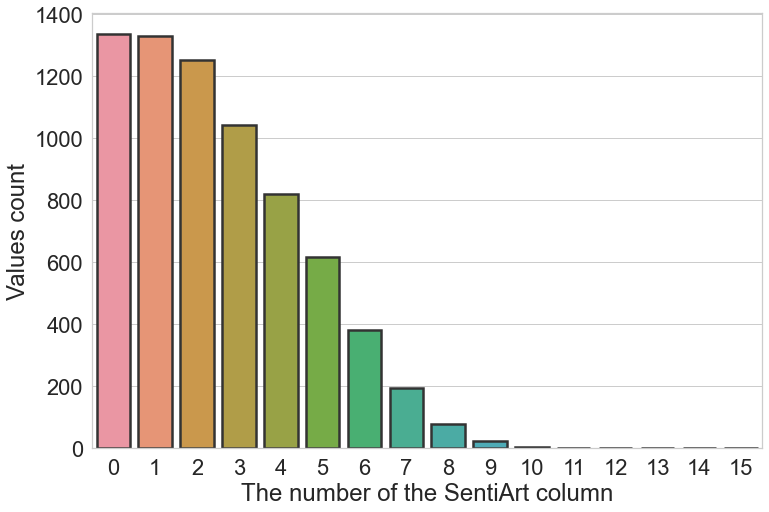

In [262]:
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
%matplotlib inline
sns.set_style('whitegrid')
rcParams['figure.figsize'] = 12, 8
ax = sns.barplot(x = df_senti.loc[:, '0':'15'].columns, y = df_senti.loc[:, '0':'15'].count(),
                 errcolor=".2", edgecolor=".2", linewidth=2.5)
ax.set(xlabel='The number of the SentiArt column', ylabel='Values count')
plt.show()

In [263]:
# Making train/test sets making sure that we have specific sentences in the test set. 

def tt_split(X, y, ind):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
    X_test = pd.concat([X_test, X.T[[x for x in dataj_c.index if x in ind]].T], axis=0)
    y_test = pd.concat([y_test, dataj_c['valence'].T[[x for x in dataj_c.index if x in ind]].T], axis=0)
    X_train = X_train.drop(ind, axis=0)
    y_train = y_train.drop(ind, axis=0)
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = tt_split(X, y, ind)

In [264]:
X_test.shape

(274, 69)

In [265]:
# Checking if the sentences we added exist only in the train set.

for i in ind:
    print("X_train: ", i in X_train.index)
    print("X_test: ", i in X_test.index)

X_train:  False
X_test:  True
X_train:  False
X_test:  True
X_train:  False
X_test:  True
X_train:  False
X_test:  True
X_train:  False
X_test:  True
X_train:  False
X_test:  True


In [266]:

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train,y_train)
# make the predictions
preds = model.predict(X_test.values)
p = pd.DataFrame(data=preds, index = X_test.index)
r2 = round(r2_score(y_test, p.values), 3)
for i in ind:
    print(dataj_c.loc[[i], ['Satz', 'valence']], '| Predicted:', round(p.loc[i, :].values[0], 3))
print('R^2 score: ', r2)


                                               Satz  valence
8506  "Harry, das ist eine phantastische Nachricht!     2.25 | Predicted: 0.095
                                          Satz  valence
1269  "Wunderbar", sagte Dumbledore strahlend.      1.9 | Predicted: 1.001
                                                      Satz  valence
890  "Hagrid wird sich freuen", sagte Dumbledore lächelnd.     1.85 | Predicted: 0.377
                             Satz  valence
10418  Snape hat ihn getötet ..."     -2.6 | Predicted: -1.209
                                         Satz  valence
10414  "Snape hat ... Dumbledore umgebracht."    -2.55 | Predicted: -1.19
                                  Satz  valence
10341  Hagrids Hütte stand in Flammen.     -2.3 | Predicted: -0.509
R^2 score:  0.284


## Step 4

In [267]:
valence_shifters = ['kaum', 'nicht', 'niemals', 'nie', 'kein', 'nein', 'aber']

good = ['Cedric', 'Dumbledore', 'Harry', 'Hagrid', 'Hermine', 'Lockhart', 'Lupin',
        'McGonagall', 'Ron', 'Snape']
bad = ['Voldemort', 'Salazar', 'Malfoy', 'Lucius', 'Grindelwald', 'Filch',
       'Bellatrix', 'Bartemius', 'Crabbe', 'Augustus']

In [268]:
def apply_shifters(w1, w2, w3, w4):
    X_valence_shifters = X.copy()

    X_valence_shifters['g'] = 0
    X_valence_shifters['b'] = 0
    k=0
    for i in X_valence_shifters.index:
            for shifter in valence_shifters:
                if shifter in data_char.loc[i, 'Satz'].lower():
                    for g in good:
                        if g in data.loc[i, 'Satz']:
                            X_valence_shifters.loc[i, 'g'] = 1
                            X_valence_shifters.loc[i, 'AAPz'] *= w1
                            X_valence_shifters.loc[i, 'sad_z'] *= w2
                
                    for b in bad:
                        if b in data.loc[i, 'Satz']:
                            k+=1
                            X_valence_shifters.loc[i, 'b'] = 1
                            X_valence_shifters.loc[i, 'AAPz'] *= w3
                            X_valence_shifters.loc[i, 'sad_z'] *= w4
    X_train, X_test, y_train, y_test = tt_split(X_valence_shifters, y, ind)

    model = CatBoostRegressor(verbose=False, thread_count=8)
    model.fit(X_train,y_train)

    preds = model.predict(X_test.values)

    p = pd.DataFrame(data=preds, index = X_test.index)
    r2 = round(r2_score(y_test, p.values), 3)
    sent = []
    r = []
    for i in ind:
        sent.append(dataj_c.loc[i, 'Satz'])
        r.append(round(p.loc[i, :].values[0], 3))
    return X_valence_shifters, {'R^2:', r2}, dict(zip(sent, r)), [w1, w2, w3, w4]

In [184]:
res = [apply_shifters(w1, w2, w3, w4) \
     for w1 in tqdm(np.arange(-2, 2, .5)) for w2 in tqdm(np.arange(-2, 2, .5), leave=False) for w3 in tqdm(np.arange(-2, 2, .5), leave=False) \
     for w4 in np.arange(-2, 2, .5)]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [12:43:37<?, ?it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [177]:
from tqdm.notebook import tqdm

res = [apply_shifters(w2, w3, w5) \
     for w2 in tqdm(np.arange(-2, 2, .5)) for w3 in np.arange(-2, 2, .5) \
     for w5 in np.arange(-2, 2, .5)]

  0%|          | 0/8 [00:00<?, ?it/s]

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [186]:
values = []
for i in range(len(res)):
    values.append(list(res[i][0]))
max(values)

for i in sorted(range(len(values)), key=lambda i: values[i])[-1:]:
    print(res[i])

({0.324, 'R^2:'}, {'"Harry, das ist eine phantastische Nachricht!': 0.156, '"Wunderbar", sagte Dumbledore strahlend.': 1.018, '"Hagrid wird sich freuen", sagte Dumbledore lächelnd.': 0.341, 'Snape hat ihn getötet ..."': -1.397, '"Snape hat ... Dumbledore umgebracht."': -1.432, 'Hagrids Hütte stand in Flammen.': -0.485}, [0.5, -0.5, -1.5, 1.5])


In [269]:
new_X, _, _, _ = apply_shifters(0.5, -0.5, -1.5, 1.5)

In [270]:
X_train, X_test, y_train, y_test = tt_split(new_X, y, ind)

model = CatBoostRegressor(verbose=False)
model.fit(X_train,y_train)

preds = model.predict(X_test.values)

p = pd.DataFrame(data=preds, index = X_test.index)
r2 = round(r2_score(y_test, p.values), 3)
for i in ind:
    print(dataj_c.loc[[i], ['Satz', 'valence']], '| Predicted:', round(p.loc[i, :].values[0], 3))
print('R^2 score: ', r2)

                                               Satz  valence
8506  "Harry, das ist eine phantastische Nachricht!     2.25 | Predicted: 0.156
                                          Satz  valence
1269  "Wunderbar", sagte Dumbledore strahlend.      1.9 | Predicted: 1.018
                                                      Satz  valence
890  "Hagrid wird sich freuen", sagte Dumbledore lächelnd.     1.85 | Predicted: 0.341
                             Satz  valence
10418  Snape hat ihn getötet ..."     -2.6 | Predicted: -1.397
                                         Satz  valence
10414  "Snape hat ... Dumbledore umgebracht."    -2.55 | Predicted: -1.432
                                  Satz  valence
10341  Hagrids Hütte stand in Flammen.     -2.3 | Predicted: -0.485
R^2 score:  0.324


In [39]:
X_valence_shifters[['AAPz', 'sad_z', 'fear_z']].head().reset_index(drop=True)

,AAPz,sad_z,fear_z
0,0.1918,-0.2280,0.3733
1,0.4305,-0.4600,-0.2560
2,0.1370,0.4312,0.5268
3,0.2975,0.0535,0.8153
4,-0.3270,0.2856,0.6164


In [247]:
X_valence_shifters.head()

,logttr,avq,acq,daq,soq,phrase_dens,ssi,word_rep,wrep_ratio,nword,ncw,cwratio,cwhr,logf,wl,nsyl,cvq,son_score,ON,HFN,ODC,chunkm,chunksu,apsum,ansum,apsumd,valspan,arospan,APn,APv,APa,APav,pnrs,posmxv,posmnv,AAPz,aroz,valz,fear_z,disg_z,hap_z,sad_z,surp_z,ang_z,ssim,cwovlp,wovlp,aapsh,arosh,surpsh,IMSconc_z,IMSAro_z,IMSima_z,IMSVal_z,pat-ncw,acq-IMS,nchar,Satz_Pos_Chapter_NEU,0,1,2,3,4,5,6,7,8,9,10,g,b
361,-0.118,0.0,0.500,4.0,2.0,7.0,13.500,2.0,0.2222,9.0,6.0,0.6667,0.7500,11.8250,4.8333,1.6667,1.5000,8.0247,7.6667,0.6667,4.2858,0.0315,0.062,0.821,-0.285,1.106,1.475,0.271,NaN,0.031,NaN,NaN,1.50,0.615,-0.245,0.1918,0.3635,0.4238,0.3733,-0.1140,0.7147,-0.2280,0.4530,0.2540,0.8716,NaN,NaN,-4.2740,-5.5630,-6.2920,-1.1340,0.0125,-0.701,0.9915,7.0,0.0,0.0,62,1.7000,0.0619,-0.2450,0.1438,-0.0400,0.0005,0.000,0.0,0.0,0.0,0.0,0,0
366,0.000,0.0,1.000,0.0,1.0,3.0,9.000,0.0,0.0000,6.0,4.0,0.6667,0.6667,7.4433,4.5000,1.5000,1.5000,6.6243,4.5000,1.0000,4.1488,0.2255,1.046,1.865,-0.143,2.008,0.840,0.174,0.5945,-0.143,NaN,NaN,3.00,0.697,-0.143,0.4305,-0.3710,0.4050,-0.2560,-0.4920,-0.5400,-0.4600,0.0005,0.2075,0.6830,NaN,NaN,4.9277,5.3047,6.2258,0.3697,-0.7450,0.867,0.8657,3.0,2.0,0.0,67,1.7000,-0.1430,0.6762,0.6967,0.4919,0.0000,0.000,0.0,0.0,0.0,0.0,0,0
368,0.000,1.0,1.000,0.0,0.0,2.0,11.667,0.0,0.0000,7.0,6.0,0.8571,0.8571,7.4153,5.3333,1.6667,2.5833,6.4873,1.3333,0.3333,4.9502,-0.0270,0.575,1.742,-0.920,2.662,1.413,0.086,-0.4300,-0.368,0.390,0.983,1.00,0.983,-0.430,0.1370,0.4092,-0.3690,0.5268,0.1007,0.2225,0.4312,0.3922,0.2770,0.7421,NaN,NaN,4.8680,5.3013,6.2735,0.0257,-0.8280,0.050,0.7027,2.0,2.0,1.0,69,-1.7000,-0.3680,0.9833,0.3895,0.3690,-0.4300,-0.122,0.0,0.0,0.0,0.0,0,0
379,0.000,0.0,0.333,4.0,0.0,6.0,10.000,0.0,0.0000,8.0,4.0,0.5000,0.5000,11.4340,3.2500,1.2500,1.6250,5.6893,8.5000,0.5000,2.9913,0.3385,0.677,1.517,-0.327,1.844,1.126,0.119,NaN,0.062,NaN,NaN,3.00,0.799,-0.327,0.2975,0.5063,0.1558,0.8153,0.0295,0.7135,0.0535,0.5135,0.2608,0.6985,NaN,NaN,-6.0070,-3.8750,-5.2690,0.6230,-0.6350,0.368,1.2560,6.0,0.0,2.0,80,0.0619,-0.3270,0.6557,0.6148,0.7990,-1.7000,0.000,0.0,0.0,0.0,0.0,0,0
391,0.000,0.5,0.250,1.0,1.0,5.0,9.800,0.0,0.0000,7.0,5.0,0.7143,0.7143,8.5132,6.0000,1.4000,3.3000,5.6506,3.2000,0.0000,5.3984,-0.4910,-1.534,0.062,-1.698,1.760,1.536,0.181,NaN,-0.020,-1.474,-0.020,0.25,0.062,-1.474,-0.3270,0.3560,-0.2920,0.6164,0.3482,0.5924,0.2856,0.4030,0.2724,0.6951,NaN,NaN,-7.7130,-4.7570,-5.4750,-1.4410,0.2480,-0.441,0.4185,5.0,0.0,0.0,92,-0.0200,-0.1020,-0.1020,0.3281,0.0619,1.7000,-1.474,0.0,0.0,0.0,0.0,0,0


## Step 5

In [271]:
def neg_pos_count(row, option) -> int:
    if option=='pos':
        return sum(n > 0 for n in row)
    if option=='neg':
        return sum(n < 0 for n in row.values)

def pos_counter(row, pos='ADJ') -> int:
    k = 0
    doc = nlp(row)
    for token in doc:
        if pos == 'AUX':
            if token.pos_ == 'AUX':
                k+=1
        if pos == 'VERB':
            if token.pos_ == 'VERB':
                k+=1
        if pos == 'PROPN':
            if token.pos_ == 'PROPN':
                k+=1
        if pos == 'NOUN':
            if token.pos_ == 'NOUN':
                k+=1
        if pos == 'ADP':
            if token.pos_ == 'ADP':
                k+=1
    
    return k

In [41]:
X_valence_shifters.head()

,logttr,avq,acq,daq,soq,phrase_dens,ssi,word_rep,wrep_ratio,nword,ncw,cwratio,cwhr,logf,wl,nsyl,cvq,son_score,ON,HFN,ODC,chunkm,chunksu,apsum,ansum,apsumd,valspan,arospan,APn,APv,APa,APav,pnrs,posmxv,posmnv,AAPz,aroz,valz,fear_z,disg_z,hap_z,sad_z,surp_z,ang_z,ssim,cwovlp,wovlp,aapsh,arosh,surpsh,IMSconc_z,IMSAro_z,IMSima_z,IMSVal_z,pat-ncw,acq-IMS,nchar,Satz_Pos_Chapter_NEU,0,1,2,3,4,5,6,7,8,9,10,g,b
361,-0.118,0.0,0.500,4.0,2.0,7.0,13.500,2.0,0.2222,9.0,6.0,0.6667,0.7500,11.8250,4.8333,1.6667,1.5000,8.0247,7.6667,0.6667,4.2858,0.0315,0.062,0.821,-0.285,1.106,1.475,0.271,NaN,0.031,NaN,NaN,1.50,0.615,-0.245,0.1918,0.3635,0.4238,0.3733,-0.1140,0.7147,-0.2280,0.4530,0.2540,0.8716,NaN,NaN,-4.2740,-5.5630,-6.2920,-1.1340,0.0125,-0.701,0.9915,7.0,0.0,0.0,62,1.7000,0.0619,-0.2450,0.1438,-0.0400,0.0005,NaN,NaN,NaN,NaN,NaN,0,0
366,0.000,0.0,1.000,0.0,1.0,3.0,9.000,0.0,0.0000,6.0,4.0,0.6667,0.6667,7.4433,4.5000,1.5000,1.5000,6.6243,4.5000,1.0000,4.1488,0.2255,1.046,1.865,-0.143,2.008,0.840,0.174,0.5945,-0.143,NaN,NaN,3.00,0.697,-0.143,0.4305,-0.3710,0.4050,-0.2560,-0.4920,-0.5400,-0.4600,0.0005,0.2075,0.6830,NaN,NaN,4.9277,5.3047,6.2258,0.3697,-0.7450,0.867,0.8657,3.0,2.0,0.0,67,1.7000,-0.1430,0.6762,0.6967,0.4919,NaN,NaN,NaN,NaN,NaN,NaN,0,0
368,0.000,1.0,1.000,0.0,0.0,2.0,11.667,0.0,0.0000,7.0,6.0,0.8571,0.8571,7.4153,5.3333,1.6667,2.5833,6.4873,1.3333,0.3333,4.9502,-0.0270,0.575,1.742,-0.920,2.662,1.413,0.086,-0.4300,-0.368,0.390,0.983,1.00,0.983,-0.430,0.1370,0.4092,-0.3690,0.5268,0.1007,0.2225,0.4312,0.3922,0.2770,0.7421,NaN,NaN,4.8680,5.3013,6.2735,0.0257,-0.8280,0.050,0.7027,2.0,2.0,1.0,69,-1.7000,-0.3680,0.9833,0.3895,0.3690,-0.4300,-0.122,NaN,NaN,NaN,NaN,0,0
379,0.000,0.0,0.333,4.0,0.0,6.0,10.000,0.0,0.0000,8.0,4.0,0.5000,0.5000,11.4340,3.2500,1.2500,1.6250,5.6893,8.5000,0.5000,2.9913,0.3385,0.677,1.517,-0.327,1.844,1.126,0.119,NaN,0.062,NaN,NaN,3.00,0.799,-0.327,0.2975,0.5063,0.1558,0.8153,0.0295,0.7135,0.0535,0.5135,0.2608,0.6985,NaN,NaN,-6.0070,-3.8750,-5.2690,0.6230,-0.6350,0.368,1.2560,6.0,0.0,2.0,80,0.0619,-0.3270,0.6557,0.6148,0.7990,-1.7000,NaN,NaN,NaN,NaN,NaN,0,0
391,0.000,0.5,0.250,1.0,1.0,5.0,9.800,0.0,0.0000,7.0,5.0,0.7143,0.7143,8.5132,6.0000,1.4000,3.3000,5.6506,3.2000,0.0000,5.3984,-0.4910,-1.534,0.062,-1.698,1.760,1.536,0.181,NaN,-0.020,-1.474,-0.020,0.25,0.062,-1.474,-0.3270,0.3560,-0.2920,0.6164,0.3482,0.5924,0.2856,0.4030,0.2724,0.6951,NaN,NaN,-7.7130,-4.7570,-5.4750,-1.4410,0.2480,-0.441,0.4185,5.0,0.0,0.0,92,-0.0200,-0.1020,-0.1020,0.3281,0.0619,1.7000,-1.474,NaN,NaN,NaN,NaN,0,0


In [272]:
d_n = new_X.copy()
d_n['pos'] = d_n.loc[:, '0':'10'].apply(neg_pos_count, args=('pos',), axis=1)
d_n['neg'] = d_n.loc[:, '0':'10'].apply(neg_pos_count, args=('neg',), axis=1)
d_n['aux'] = dataj_char['Satz'].apply(pos_counter, args=('AUX', ))
d_n['verbs'] = dataj_char['Satz'].apply(pos_counter, args=('VERB', ))
d_n['propn'] = dataj_char['Satz'].apply(pos_counter, args=('PROPN', ))
d_n['noun'] = dataj_char['Satz'].apply(pos_counter, args=('NOUN', ))
d_n['adp'] = dataj_char['Satz'].apply(pos_counter, args=('ADP', ))
d_n['avg'] = d_n.loc[:, '0':'10'].mean(axis=1)


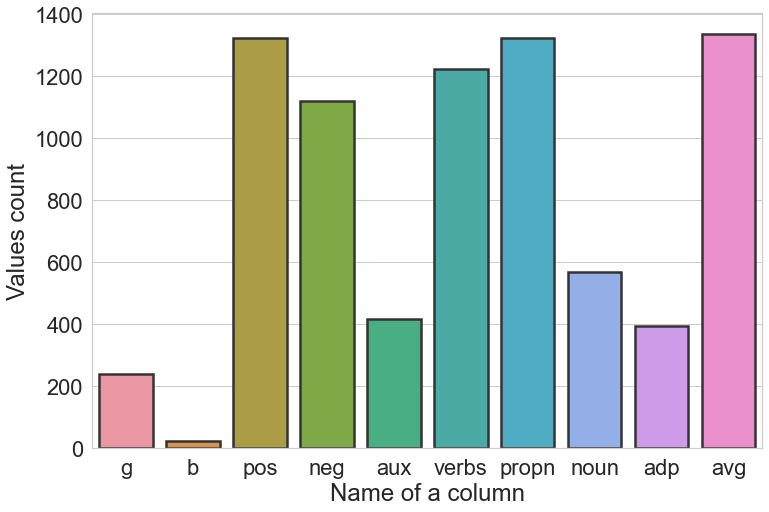

In [273]:
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
%matplotlib inline
sns.set_style('whitegrid')
rcParams['figure.figsize'] = 12, 8
ax = sns.barplot(x = d_n.loc[:, 'g':'avg'].columns, y = d_n.loc[:, 'g':'avg'][d_n.loc[:, 'g':'avg']!=0].count(),
                 errcolor=".2", edgecolor=".2", linewidth=2.5)
ax.set(xlabel='Name of a column', ylabel='Values count')
plt.show()

In [34]:
#the number of verbs, proper nouns, nouns, adpositions, and the average value of the SentiArt’s vectors
d_n.loc[:, 'g':'avg'].head()

,g,b,pos,neg,aux,verbs,propn,noun,adp,avg
361,0,0,4,2,0,2,1,0,1,0.270200
366,0,0,4,1,0,1,2,2,1,0.684360
368,0,0,3,4,0,1,1,1,0,-0.125457
379,0,0,4,2,0,1,2,1,1,0.017400
391,0,0,3,4,0,2,1,0,0,0.056000


In [194]:
import itertools

columns = list(d_n.loc[:, 'g':'avg'].columns)
print(columns)
all_combinations = []
for r in range(len(columns) + 1):

    combinations_object = itertools.combinations(columns, r)
    combinations_list = list(combinations_object)
    all_combinations += combinations_list

d_n_upd = d_n.copy()
def model(columns, d_n_upd):
    d_n_upd = d_n_upd.drop(columns=columns)
    X_train, X_test, y_train, y_test = tt_split(d_n_upd, y, ind)

    model = CatBoostRegressor(verbose=False)
    #train the model
    model.fit(X_train,y_train)
    # make the predictions
    preds = model.predict(X_test)
    p = pd.DataFrame(data=preds, index = X_test.index)
    r2 = round(r2_score(y_test, p.values), 3)

    sent = []
    r = []
    for i in ind:
        sent.append(dataj_c.loc[i, 'Satz'])
        r.append(round(p.loc[i, :].values[0], 3))
    return r2, dict(zip(sent, r)), columns

import collections
results= collections.defaultdict(dict)
for i in tqdm(range((len([list(x) for x in all_combinations])))):
    output = model(list(all_combinations[i]), d_n_upd)
    results[str(i)]['R^2'], results[str(i)]['Sentences'], results[str(i)]['Columns'] = output


['g', 'b', 'pos', 'neg', 'aux', 'verbs', 'propn', 'noun', 'adp', 'avg']


  0%|          | 0/1024 [00:00<?, ?it/s]

In [195]:
score = []
for key in results.keys():
    score.append(results[key]['R^2'])
results[str(score.index(max(score)))]

{'R^2': 0.328,
 'Sentences': {'"Harry, das ist eine phantastische Nachricht!': 0.205,
  '"Wunderbar", sagte Dumbledore strahlend.': 1.036,
  '"Hagrid wird sich freuen", sagte Dumbledore lächelnd.': 0.41,
  'Snape hat ihn getötet ..."': -1.122,
  '"Snape hat ... Dumbledore umgebracht."': -1.271,
  'Hagrids Hütte stand in Flammen.': -0.619},
 'Columns': ['verbs', 'propn', 'noun', 'adp', 'avg']}

In [337]:
#d_n[['pos', 'verbs', 'noun', 'aux', 'avg']].head().reset_index(drop=True)

In [274]:
d_n_upd = d_n.copy()
d_n_upd = d_n_upd.drop(columns=['verbs', 'propn', 'noun', 'adp', 'avg'])
X_train, X_test, y_train, y_test = tt_split(d_n_upd, y, ind)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

model = CatBoostRegressor(verbose=False)
#train the model
model.fit(X_train,y_train)
# make the predictions
preds = model.predict(X_test)
p = pd.DataFrame(data=preds, index = X_test.index)
r2 = round(r2_score(y_test, p.values), 3)
for i in ind:
    print(dataj_c.loc[[i], ['Satz', 'valence']], '| Predicted:', round(p.loc[i, :], 3))
print('R^2 score: ', r2)

(1062, 74) (1062,)
(274, 74) (274,)
                                               Satz  valence
8506  "Harry, das ist eine phantastische Nachricht!     2.25 | Predicted: 0    0.205
Name: 8506, dtype: float64
                                          Satz  valence
1269  "Wunderbar", sagte Dumbledore strahlend.      1.9 | Predicted: 0    1.036
Name: 1269, dtype: float64
                                                      Satz  valence
890  "Hagrid wird sich freuen", sagte Dumbledore lächelnd.     1.85 | Predicted: 0    0.41
Name: 890, dtype: float64
                             Satz  valence
10418  Snape hat ihn getötet ..."     -2.6 | Predicted: 0   -1.122
Name: 10418, dtype: float64
                                         Satz  valence
10414  "Snape hat ... Dumbledore umgebracht."    -2.55 | Predicted: 0   -1.271
Name: 10414, dtype: float64
                                  Satz  valence
10341  Hagrids Hütte stand in Flammen.     -2.3 | Predicted: 0   -0.619
Name: 10341, dtype: flo

## Step 6

In [291]:
X_test.loc[8506:10341, :]

,logttr,avq,acq,daq,soq,phrase_dens,ssi,word_rep,wrep_ratio,nword,ncw,cwratio,cwhr,logf,wl,nsyl,cvq,son_score,ON,HFN,ODC,chunkm,chunksu,apsum,ansum,apsumd,valspan,arospan,APn,APv,APa,APav,pnrs,posmxv,posmnv,AAPz,aroz,valz,fear_z,disg_z,hap_z,sad_z,surp_z,ang_z,ssim,cwovlp,wovlp,aapsh,arosh,surpsh,IMSconc_z,IMSAro_z,IMSima_z,IMSVal_z,pat-ncw,acq-IMS,nchar,Satz_Pos_Chapter_NEU,0,1,2,3,4,5,6,7,8,9,10,g,b,pos,verbs,propn,noun,avg
8506,0.0,1.0,0.667,2.0,1.0,3.0,12.00,0.0,0.0,6.0,5.0,0.8333,0.8333,9.6330,6.40,2.00,2.0166,6.8808,3.60,0.0,5.354,0.6300,2.254,3.053,-0.184,3.237,2.355,0.056,-0.184,0.267,2.171,NaN,4.0,2.171,-0.184,0.5738,0.3498,0.6980,0.3618,-0.210,0.7448,0.2124,1.6632,0.2286,0.6754,0.0,2.0,61.033,21.020,32.259,-1.1920,0.840,-0.2390,0.8258,3.0,3.0,0.0,39.0,2.5000,0.3281,0.2667,0.2871,2.171,-0.184,NaN,NaN,NaN,NaN,NaN,0.0,0.0,5.0,0.0,1.0,1.0,0.894817
10341,0.0,0.0,1.000,2.0,0.0,4.0,6.25,0.0,0.0,5.0,4.0,0.8000,0.8000,7.8868,4.75,1.25,2.6250,5.6073,2.75,0.5,4.418,0.4717,1.415,2.295,-0.204,2.499,1.413,0.073,1.209,0.103,NaN,NaN,3.0,1.209,-0.204,0.5228,0.3105,0.2083,0.4855,-0.115,0.5720,0.1595,0.8218,0.2743,0.7156,0.0,1.0,33.212,25.168,36.877,0.0155,-0.171,0.4215,0.3780,4.0,1.0,2.0,57.0,1.2086,0.4100,0.6762,-0.2040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,3.0,1.0,1.0,2.0,0.522700


In [645]:
X_test.index
f= open("test_indexes.txt","w+")
f.write(list(X_test.index))

TypeError: write() argument must be str, not list

In [671]:
years = list(X_test.index)
with open('test_indexes.txt', 'w') as file:
    file.write('\n'.join(str(year) for year in years))

In [673]:
len(list(X_test.index))

274

In [681]:
with open('test_indexes.txt') as f:
    w = [int(x) for x in next(f).split()]
    array = [[int(x) for x in line.split()] for line in f]
    indexes = [item for sublist in array for item in sublist]
len(indexes)

AttributeError: '_io.TextIOWrapper' object has no attribute 'split'

In [275]:
# diff = pd.DataFrame(data = y_test.values.astype(float), columns=['true'], index=y_test.index)
# diff['pred'] = preds.astype(float)
# diff['Satz'] = dataj.T[X_test.T.columns].T['Satz'].values
# diff['Diff'] = list(abs(y_test - preds))
# print('R^2 before: ', round(r2_score(diff.true, diff.pred), 3))
# print(diff.shape)
dif = pd.DataFrame(data = y_test.values.astype(float), columns=['true'], index=y_test.index)
dif['pred'] = preds.astype(float)
dif['Satz'] = dataj.T[X_test.T.columns].T['Satz'].values
dif['Diff'] = list(abs(y_test - preds))
print('R^2 before: ', round(r2_score(dif.true, dif.pred), 3))
print(dif.shape)
def apply_weights_on_preds(w1, w2, w3):
    diff = dif.copy()
    count=0
    for i in diff.index:
        for shifter in valence_shifters:
            if shifter in diff.loc[i, 'Satz'].lower():
                count+=1
                if diff.loc[i, 'pred'] >= 0.0:
                    for g in good:
                        if g in diff.loc[i, 'Satz']:
                            diff.loc[i, 'pred'] = diff.loc[i, 'pred'] +w1#*(-1)
                    for b in bad:
                        if b in diff.loc[i, 'Satz']:
                            diff.loc[i, 'pred'] = diff.loc[i, 'pred'] +w2# * 4

                if diff.loc[i, 'pred'] < 0.0:
                    for g in good:
                        if g in diff.loc[i, 'Satz']:
                            diff.loc[i, 'pred'] = diff.loc[i, 'pred']+w3#.05#*(.9)
                    for b in bad:
                        if b in diff.loc[i, 'Satz']:
                            diff.loc[i, 'pred'] = diff.loc[i, 'pred']*(1) # there are no such sentences
    r2 = round(r2_score(diff.true.values, diff.pred.values),3)
    sent = []
    r = []
    for i in ind:
        sent.append(dataj_c.loc[i, 'Satz'])
        r.append(round(diff.loc[i, 'pred'], 3))
    return diff, r2, dict(zip(sent, r)), [w1, w2, w3]

# res = [apply_weights_on_preds(w1, w2, w3) for w1 in tqdm(np.arange(-2, 2, 0.1)) \
#         for w2 in np.arange(-2, 2, 0.1) for w3 in np.arange(-2, 2, 0.1)]


# for i in ind:
#     print(dataj.loc[[i], ['Satz', 'valence']], '| Predicted:', round(diff.loc[[i], ['pred']].values[0][0],3))
# print('R^2 after: ', round(r2_score(diff.true.values, diff.pred.values),3))


R^2 before:  0.328
(274, 4)


In [276]:
import collections
from operator import attrgetter
from typing import Iterable, List, Optional, Pattern, Tuple

from cytoolz import itertoolz
from spacy.symbols import (
    AUX, VERB,
    agent, attr, aux, auxpass, csubj, csubjpass, dobj, neg, nsubj, nsubjpass, obj, pobj, xcomp
)
from spacy.tokens import Doc, Span, Token

import matches
import constants, types, utils


_NOMINAL_SUBJ_DEPS = {'sb', 'nsubj', 'nsubj:pass'}
_CLAUSAL_SUBJ_DEPS = {'csubj', 'csubjpass'}

SVOTriple: Tuple[List[Token], List[Token], List[Token]] = collections.namedtuple(
    "SVOTriple", ["subject", "verb", "object"]
)

def subject_verb_object_triples(doclike):
    """
    Extract an ordered sequence of subject-verb-object triples from a document
    or sentence.

    Args:
        doclike

    Yields:
        Next SVO triple as (subject, verb, object), in approximate order of appearance.
    """
    if isinstance(doclike, Span):
        sents = [doclike]
    else:
        sents = doclike.sents

    for sent in sents:
        # connect subjects/objects to direct verb heads
        # and expand them to include conjuncts, compound nouns, ...
        verb_sos = collections.defaultdict(lambda: collections.defaultdict(set))
        for tok in sent:
            head = tok.head
            # ensure entry for all verbs, even if empty
            # to catch conjugate verbs without direct subject/object deps
            if tok.pos_ == 'VERB':
                _ = verb_sos[tok]
            # nominal subject of active or passive verb
            if tok.dep_ in _NOMINAL_SUBJ_DEPS:
                if head.pos_ == 'VERB':
                    verb_sos[head]["subjects"].update(expand_noun(tok))
            # clausal subject of active or passive verb
            elif tok.dep_ in _CLAUSAL_SUBJ_DEPS:
                if head.pos_ == 'VERB':
                    verb_sos[head]["subjects"].update(tok.subtree)
            # nominal direct object of transitive verb
            elif tok.dep_ == 'oa':
                if head.pos_ == 'VERB':
                    verb_sos[head]["objects"].update(expand_noun(tok))
            # prepositional object acting as agent of passive verb
            elif tok.dep_ == 'acl':
                if head.dep_ == 'agent' and head.head.pos_ == 'VERB':
                    verb_sos[head.head]["objects"].update(expand_noun(tok))
            # open clausal complement, but not as a secondary predicate
            elif tok.dep_ == 'xcomp':
                if (
                    head.pos_ == 'VERB'
                    and not any(child.dep_ == 'dobj' for child in head.children)
                ):
                    # TODO: just the verb, or the whole tree?
                    # verb_sos[verb]["objects"].update(expand_verb(tok))
                    verb_sos[head]["objects"].update(tok.subtree)
        #return verb_sos
        #fill in any indirect relationships connected via verb conjuncts
        for verb, so_dict in verb_sos.items():
            conjuncts = verb.conjuncts
            if so_dict.get("subjects"):
                for conj in conjuncts:
                    conj_so_dict = verb_sos.get(conj)
                    if conj_so_dict and not conj_so_dict.get("subjects"):
                        conj_so_dict["subjects"].update(so_dict["subjects"])
            if not so_dict.get("objects"):
                so_dict["objects"].update(
                    obj
                    for conj in conjuncts
                    for obj in verb_sos.get(conj, {}).get("objects", [])
                )
        # expand verbs and restructure into svo triples
        for verb, so_dict in verb_sos.items():
            if so_dict["subjects"] and so_dict["objects"]:
                yield SVOTriple(
                    subject=sorted(so_dict["subjects"], key=attrgetter("i")),
                    verb=sorted(expand_verb(verb), key=attrgetter("i")),
                    object=sorted(so_dict["objects"], key=attrgetter("i")),
                )

In [147]:
spacy.explain('oa')

'accusative object'

In [148]:
spacy.explain('pobj')

'object of preposition'

In [149]:
spacy.explain('dobj')

'direct object'

In [150]:
spacy.explain('nsubj')

'nominal subject'

In [144]:
spacy.explain('nsubj:pass')

In [145]:
spacy.explain('agent')

'agent'

In [146]:
spacy.explain('xcomp')

'open clausal complement'

In [153]:
spacy.explain('csubj')

'clausal subject'

In [164]:
spacy.explain('obj')

'object'

In [277]:
nlp = spacy.load("de_core_news_lg")

In [216]:
r = [apply_weights_on_preds(w1, w2, w3) for w1 in tqdm(np.arange(-2, 2, .1)) for w2 in np.arange(-2, 2, .1) \
     for w3 in np.arange(-2, 2, .1)]

  0%|          | 0/40 [00:00<?, ?it/s]

In [278]:
diff, _, _, _ = apply_weights_on_preds(-0.2, 2, 0)
diff['triplets'] = 'None'
for i in diff.T.columns:
    p = subject_verb_object_triples(nlp(diff.loc[i, 'Satz']))
    for k in p:
        diff.loc[i, 'triplets'] = str(list(k[:]))

In [283]:


def applying_weights_based_on_the_SVOTriplets(w1, w2, w3, w4, w5, w6, w7, w8):
    d_n_tr = d_n_upd.copy()
    k = 0
    dataf = data_char[data_char.triplets!='None']
    out = diff.copy()
    a,b,c,d,e,f,g,h=0,0,0,0,0,0,0,0
    indexes = []
    for i in dataf.index:
        if dataf.loc[i, 'triplets'][-1] == 'sich':
            dataf.loc[i, 'triplets'][-1] = dataf.loc[i, 'triplets'][0]
        try:
            if dataf.loc[i, 'triplets'][0] in good and dataf.loc[i, 'triplets'][-1] in good and lookup(dataf.loc[i, 'triplets'][1], sa) < 0:
                indexes.append(i)
                a+=1
                d_n_tr.loc[i, 'AAPz'] *= w1
            if dataf.loc[i, 'triplets'][0] in good and dataf.loc[i, 'triplets'][-1] in good and lookup(dataf.loc[i, 'triplets'][1], sa) >= 0:
                b+=1
                indexes.append(i)
                d_n_tr.loc[i, 'AAPz'] *= w2


            if dataf.loc[i, 'triplets'][0] in good and dataf.loc[i, 'triplets'][-1] in bad and lookup(dataf.loc[i, 'triplets'][1], sa) < 0:
                c+=1
                indexes.append(i)
                d_n_tr.loc[i, 'AAPz'] *= w3
            if dataf.loc[i, 'triplets'][0] in good and dataf.loc[i, 'triplets'][-1] in bad and lookup(dataf.loc[i, 'triplets'][1], sa) >= 0:
                d+=1
                indexes.append(i)
                dataf.loc[i, 'AAPz'] *= w4


            if dataf.loc[i, 'triplets'][0] in bad and dataf.loc[i, 'triplets'][-1] in good and lookup(dataf.loc[i, 'triplets'][1], sa) >= 0:
                e+=1
                indexes.append(i)
                d_n_tr.loc[i, 'AAPz'] *= w5
            if dataf.loc[i, 'triplets'][0] in bad and dataf.loc[i, 'triplets'][-1] in good and lookup(dataf.loc[i, 'triplets'][1], sa) < 0:
                f+=1
                indexes.append(i)
                d_n_tr.loc[i, 'AAPz'] *= w6

            if dataf.loc[i, 'triplets'][0] in bad and dataf.loc[i, 'triplets'][-1] in bad and lookup(dataf.loc[i, 'triplets'][1], sa) < 0:
                g+=1
                indexes.append(i)
                d_n_tr.loc[i, 'AAPz'] *= w7
            if dataf.loc[i, 'triplets'][0] in bad and dataf.loc[i, 'triplets'][-1] in bad and lookup(dataf.loc[i, 'triplets'][1], sa) >= 0:
                h+=1
                indexes.append(i)
                d_n_tr.loc[i, 'AAPz'] *= w8
        except: pass
    print(a, b, c, d, e, f, g, h)
    X_train, X_test, y_train, y_test = tt_split(d_n_tr, y, ind)

    model = CatBoostRegressor(verbose=False, thread_count=8)
    model.fit(X_train,y_train)

    preds = model.predict(X_test.values)

    p = pd.DataFrame(data=preds, index = X_test.index)
    r2 = round(r2_score(y_test, p.values), 3)
    sent = []
    r = []
    for i in ind:
        sent.append(dataj_c.loc[i, 'Satz'])
        r.append(round(p.loc[i, :].values[0], 3))
    return d_n_tr, {'R^2:', r2}, dict(zip(sent, r)), [w1, w2, w3, w4, w5, w6, w7 ,w8]


In [39]:
applying_weights_based_on_the_SVOTriplets(1, 1, 1, 1, 1, 1, 1, 1)[1]

13 11 2 0 0 1 0 4


{0.328, 'R^2:'}

In [286]:
def applying_weights_based_on_the_SVOTriplets(w1, w2, w3, w4):
    d_n_tr = d_n_upd.copy()
    k = 0
    dataf = data_char[data_char.triplets!='None']
    a,b,c,d,e,f=0,0,0,0,0,0
    indexes = []
    for i in dataf.index:
        if dataf.loc[i, 'triplets'][-1] == 'sich':
            dataf.loc[i, 'triplets'][-1] = dataf.loc[i, 'triplets'][0]
        if dataf.loc[i, 'triplets'][0] in bad:
            a+=1
            d_n_tr.loc[i, 'AAPz'] *= w1
        if dataf.loc[i, 'triplets'][0] in good:
            b+=1
            d_n_tr.loc[i, 'AAPz'] *= w2
        if dataf.loc[i, 'triplets'][-1] in good:
            c+=1
            d_n_tr.loc[i, 'AAPz'] *= w3
        if dataf.loc[i, 'triplets'][-1] in bad:
            d+=1
            d_n_tr.loc[i, 'AAPz'] *= w4
    X_train, X_test, y_train, y_test = tt_split(d_n_tr, y, ind)

    model = CatBoostRegressor(verbose=False, thread_count=8)
    model.fit(X_train,y_train)

    preds = model.predict(X_test.values)

    p = pd.DataFrame(data=preds, index = X_test.index)
    r2 = round(r2_score(y_test, p.values), 3)
    sent = []
    r = []
    for i in ind:
        sent.append(dataj_c.loc[i, 'Satz'])
        r.append(round(p.loc[i, :].values[0], 3))
    return d_n_tr, r2, dict(zip(sent, r)), [w1, w2, w3, w4]


In [299]:
interval = np.arange(-2, 2, .5)

r = [applying_weights_based_on_the_SVOTriplets(w1, w2, w3, w4) for w1 in tqdm(interval) for w2 in tqdm(interval, leave=False) \
     for w3 in interval for w4 in interval]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [360]:
values = []
for i in range(len(r)):
    values.append(r[i][1])
max(values)

for i in sorted(range(len(values)), key=lambda i: values[i])[-2:]:
    print(r[i][1:])

IndexError: invalid index to scalar variable.

In [285]:
final_data, r2, _, _ = applying_weights_based_on_the_SVOTriplets(-1.5, -1.5, 1.5, 1.0)
r2

0.338

# SA + BERT

In [51]:
bert_embs = pd.read_csv('/Users/alexcrystal/PycharmProjects/pythonProject/thesis/data/embeddings/embeddings_bert_10-12.csv')
bert_embs.index = bert_embs['Unnamed: 0']
bert_embs = bert_embs.drop(columns=['Unnamed: 0'])
# bert_embs = bert_embs.drop(columns=['Unnamed: 0'])


In [52]:
bert_embs.columns = [x+1000 for x in range(len(bert_embs.columns))]
bert_embs.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343,1344,1345,1346,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500,1501,1502,1503,1504,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514,1515,1516,1517,1518,1519,1520,1521,1522,1523,1524,1525,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612,1613,1614,1615,1616,1617,1618,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1630,1631,1632,1633,1634,1635,1636,1637,1638,1639,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682,1683,1684,1685,1686,1687,1688,1689,1690,1691,1692,1693,1694,1695,1696,1697,1698,1699,1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,1710,1711,1712,1713,1714,1715,1716,1717,1718,1719,1720,1721,1722,1723,1724,1725,1726,1727,1728,1729,1730,1731,1732,1733,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [53]:
X_train, X_test, y_train, y_test = tt_split(final_data, y, ind)

model = CatBoostRegressor(verbose=False, thread_count=8)
model.fit(X_train,y_train)

preds = model.predict(X_test.values)

p = pd.DataFrame(data=preds, index = X_test.index)
r2 = round(r2_score(y_test, p.values), 3)
r2


0.338

In [54]:
# Single layers + SENTIART
r_sl_sa = []

for i in tqdm(range(0, 13)):
    bert_embs = pd.read_csv('/Users/alexcrystal/PycharmProjects/pythonProject/thesis/data/embeddings/embeddings_bert_'+str(i)+'.csv')
    bert_embs.index = bert_embs['Unnamed: 0']
    bert_embs = bert_embs.drop(columns=['Unnamed: 0'])
    bert_embs.columns = [x+1000 for x in range(len(bert_embs.columns))]
    
    X_train_new = X_train.merge(bert_embs, how='left', left_index=True, right_index=True)
    X_test_new = X_test.merge(bert_embs, how='left', left_index=True, right_index=True)

    model = CatBoostRegressor(verbose=False)
    #train the model
    model.fit(X_train_new, y_train)
    # make the predictions
    preds = model.predict(X_test_new)
    p = pd.DataFrame(data=preds, index = X_test_new.index)
    r2 = round(r2_score(y_test, p.values), 3)
    r_sl_sa.append(r2)


100%|██████████| 13/13 [06:53<00:00, 31.81s/it]


In [55]:
# ONLY BERT multiple layers SUM
r = []

for i in tqdm(range(6, 12)):
    bert_embs = pd.read_csv('/Users/alexcrystal/PycharmProjects/pythonProject/thesis/data/embeddings/embeddings_bert_'+str(i)+'-12_sum.csv')
    bert_embs.index = bert_embs['Unnamed: 0']
    bert_embs = bert_embs.drop(columns=['Unnamed: 0'])
    bert_embs.columns = [x+1000 for x in range(len(bert_embs.columns))]

    model = CatBoostRegressor(verbose=False)
    #train the model
    model.fit(bert_embs.loc[X_train.index, :], y_train)
    # make the predictions
    preds = model.predict(bert_embs.loc[X_test.index, :])
    p = pd.DataFrame(data=preds, index = X_test.index)
    r2 = round(r2_score(y_test, p.values), 3)
    print('Layer: ', i, ' R^2: ', r2)
    r.append(r2)


 17%|█▋        | 1/6 [00:32<02:42, 32.52s/it]

Layer:  6  R^2:  0.24


 33%|███▎      | 2/6 [01:05<02:10, 32.59s/it]

Layer:  7  R^2:  0.247


 50%|█████     | 3/6 [01:35<01:35, 31.74s/it]

Layer:  8  R^2:  0.272


 67%|██████▋   | 4/6 [02:06<01:02, 31.34s/it]

Layer:  9  R^2:  0.301


 83%|████████▎ | 5/6 [02:39<00:31, 31.86s/it]

Layer:  10  R^2:  0.335


100%|██████████| 6/6 [03:09<00:00, 31.66s/it]

Layer:  11  R^2:  0.398


In [56]:
# ONLY BERT multiple layers AVERAGE
r_avg = []

for i in tqdm(range(6, 12)):
    bert_embs = pd.read_csv('/Users/alexcrystal/PycharmProjects/pythonProject/thesis/data/embeddings/embeddings_bert_'+str(i)+'-12.csv')
    bert_embs.index = bert_embs['Unnamed: 0']
    bert_embs = bert_embs.drop(columns=['Unnamed: 0'])
    bert_embs.columns = [x+1000 for x in range(len(bert_embs.columns))]

    model = CatBoostRegressor(verbose=False)
    #train the model
    model.fit(bert_embs.loc[X_train.index, :], y_train)
    # make the predictions
    preds = model.predict(bert_embs.loc[X_test.index, :])
    p = pd.DataFrame(data=preds, index = X_test.index)
    r2 = round(r2_score(y_test, p.values), 3)
    print('Layer: ', i, ' R^2: ', r2)
    r_avg.append(r2)


 17%|█▋        | 1/6 [00:28<02:23, 28.75s/it]

Layer:  6  R^2:  0.042


 33%|███▎      | 2/6 [00:56<01:53, 28.37s/it]

Layer:  7  R^2:  0.138


 50%|█████     | 3/6 [01:26<01:26, 28.87s/it]

Layer:  8  R^2:  0.143


 67%|██████▋   | 4/6 [01:57<00:59, 29.85s/it]

Layer:  9  R^2:  0.034


 83%|████████▎ | 5/6 [02:26<00:29, 29.52s/it]

Layer:  10  R^2:  0.134


100%|██████████| 6/6 [02:55<00:00, 29.27s/it]

Layer:  11  R^2:  0.134


In [338]:
print(len([x for x in X_train.index if x in bert_embs.index]), X_train.shape)

1062 (1062, 74)


In [340]:
r

[0.24, 0.247, 0.272, 0.301, 0.335, 0.398]

In [57]:
# Single layers

r_sl = []

for i in range(0, 12):
    bert_embs = pd.read_csv('/Users/alexcrystal/PycharmProjects/pythonProject/thesis/data/embeddings/embeddings_bert_'+str(i)+'.csv')
    bert_embs.index = bert_embs['Unnamed: 0']
    bert_embs = bert_embs.drop(columns=['Unnamed: 0'])
    
    model = CatBoostRegressor(verbose=False)
    #train the model
    model.fit(bert_embs.loc[X_train.index, :], y_train)
    # make the predictions
    preds = model.predict(bert_embs.loc[X_test.index, :])
    p = pd.DataFrame(data=preds, index = X_test.index)
    r2 = round(r2_score(y_test, p.values), 3)
    r_sl.append(r2)


In [58]:
layers = [x for x in range(1, 13)]

In [59]:
r2l = pd.DataFrame(data=r, columns=['r'])
r2l['layer'] = layers

ValueError: Length of values (12) does not match length of index (6)

In [342]:
# ONLY BERT

import plotly.graph_objects as go

fig = go.Figure(go.Scatter(y  = r2l['r'], x = r2l['layer'], mode = 'text+lines+markers', text = r2l['r'], textposition='top center'))

fig.update_traces(marker=dict(size=12))

fig.update_layout(
    font_family="Times Newer Roman",
    font_color="black",
    title_font_family="Times New Roman",
    font_size=16,
    xaxis_title="Layer number",
    yaxis_title="R^2 value",
)

config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'r2_layers',
    'height': 1080,
    'width': 1920,
    'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

fig.update_xaxes(#tickangle=45,
                 tickmode = 'array',
                 tickvals = r2l['layer'])
                # ticktext= [d.strftime('%Y-%m-%d') for d in datelist])

fig.show(config={'toImageButtonOptions': {'width': None, 'height': None}})

In [60]:
# ONLY BERT MULTIPLE LAYERS AVERAGE

layers = [x for x in range(6, 12)]

r2l = pd.DataFrame(data=r, columns=['r'])
r2l['layer'] = layers

import plotly.graph_objects as go

fig = go.Figure(go.Scatter(y  = r2l['r'], x = r2l['layer'], mode = 'text+lines+markers', text = r2l['r'], textposition='top center'))

fig.update_traces(marker=dict(size=12))

fig.update_layout(
    font_family="Times Newer Roman",
    font_color="black",
    title_font_family="Times New Roman",
    font_size=16,
    xaxis_title="Layer number",
    yaxis_title="R^2 value",
)

config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'r2_layers',
    'height': 1080,
    'width': 1920,
    'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

fig.update_xaxes(#tickangle=45,
                 tickmode = 'array',
                 tickvals = r2l['layer'])
                # ticktext= [d.strftime('%Y-%m-%d') for d in datelist])

fig.show(config={'toImageButtonOptions': {'width': None, 'height': None}})

In [61]:
# ONLY BERT MULTIPLE LAYERS SUM

layers = [x for x in range(6, 12)]

r2l = pd.DataFrame(data=r, columns=['r'])
r2l['layer'] = layers

import plotly.graph_objects as go

fig = go.Figure(go.Scatter(y  = r2l['r'], x = r2l['layer'], mode = 'text+lines+markers', text = r2l['r'], textposition='top center'))

fig.update_traces(marker=dict(size=12))

fig.update_layout(
    font_family="Times Newer Roman",
    font_color="black",
    title_font_family="Times New Roman",
    font_size=16,
    xaxis_title="Layer number",
    yaxis_title="R^2 value",
)

config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'r2_layers',
    'height': 1080,
    'width': 1920,
    'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

fig.update_xaxes(#tickangle=45,
                 tickmode = 'array',
                 tickvals = r2l['layer'])
                # ticktext= [d.strftime('%Y-%m-%d') for d in datelist])

fig.show(config={'toImageButtonOptions': {'width': None, 'height': None}})

In [346]:
-r2l['layer'] + 12

0    6
1    5
2    4
3    3
4    2
5    1
Name: layer, dtype: int64

In [65]:
# ONLY BERT MULTIPLE LAYERS SUM + AVERAGE

layers = [x for x in range(6, 12)]

r2l = pd.DataFrame(data=r, columns=['r_sum'])
r2l['layer'] = layers
r2l['r_avg'] = r_avg

import plotly.graph_objects as go

fig = go.Figure()
[6, 5, 4, 3, 2, 1]
fig.add_trace(go.Scatter(y  = r2l['r_sum'], x = [6, 5, 4, 3, 2, 1], mode = 'text+lines+markers', text = r2l['r_sum'], \
    textposition='top center', name = 'Summing'))

fig.add_trace(go.Scatter(y  = r2l['r_avg'], x = [6, 5, 4, 3, 2, 1], mode = 'text+lines+markers', text = r2l['r_avg'], \
    textposition='top center', name = 'Averaging'))

fig.update_traces(marker=dict(size=12))

fig.update_layout(
    font_family="Times Newer Roman",
    font_color="black",
    title_font_family="Times New Roman",
    font_size=16,
    xaxis_title="The number of layers in use",
    yaxis_title="R^2 value"
)

config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'r2_layers',
    'height': 1080,
    'width': 1920,
    'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
axis = -r2l['layer'] + 12
fig.update_xaxes(#tickangle=45,
                 #tickmode = 'array',
                 tickvals = [str(x) for x in axis.values],
                 type='category',
                 autorange = False)
                # ticktext= [d.strftime('%Y-%m-%d') for d in datelist])
fig['layout']['xaxis']['autorange'] = "reversed"
fig.show(config={'toImageButtonOptions': {'width': None, 'height': None}})

In [66]:
import plotly.io as pio
pio.write_image(fig, './images/fig8.png', width=1000, height=700)

In [69]:
# ONLY BERT SINGLE LAYERS + SA

layers = [x for x in range(1, 13)]
print(len(layers))
print(len(r_sl))
print(len(r_sl_sa))
r2l = pd.DataFrame(data=r_sl[:12], columns=['r_sl'])
r2l['layer'] = layers
r2l['r_sl_sa'] = r_sl_sa[:12]

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(y  = r2l['r_sl'], x = r2l['layer'], mode = 'text+lines+markers', text = r2l['r_sl'], \
    textposition='top center', name = '''Only BERT's embeddings'''))

fig.add_trace(go.Scatter(y  = r2l['r_sl_sa'], x = r2l['layer'], mode = 'text+lines+markers', text = r2l['r_sl_sa'], \
    textposition='top center', name = '''BERT's embeddings + SentiArt's features'''))

fig.update_traces(marker=dict(size=12))

fig.update_layout(
    font_family="Times Newer Roman",
    font_color="black",
    title_font_family="Times New Roman",
    font_size=16,
    xaxis_title="Layer number",
    yaxis_title="R^2 value"
)

config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'r2_layers',
    'height': 1080,
    'width': 1920,
    'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

fig.update_xaxes(#tickangle=45,
                 #tickmode = 'array',
                 tickvals = r2l['layer'],
                 type='category',
                 autorange = True)
                # ticktext= [d.strftime('%Y-%m-%d') for d in datelist])
# fig['layout']['xaxis']['autorange'] = "reversed"
fig.show(config={'toImageButtonOptions': {'width': None, 'height': None}})

12
12
13


In [352]:
import plotly.io as pio
pio.write_image(fig, './images/r2_nlayers_sa.png', width=1000, height=700)

In [146]:
import plotly.graph_objects as go

fig = go.Figure(go.Scatter(y  = r2l['r'], x = r2l['layer']))

fig.update_traces(marker=dict(size=12))

fig.update_layout(
    font_family="Times Newer Roman",
    font_color="black",
    title_font_family="Times New Roman",
    font_size=16,
    xaxis_title="Layer number",
    yaxis_title="R^2 value",
)

config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'r2_layers',
    'height': 1080,
    'width': 1920,
    'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

fig.show(config=config)

In [127]:
import plotly.io as pio
pio.write_image(fig, '/images/r2_layers.png', width=1920, height=1080)

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
